# Hyperparameters tuning

In [1]:
import os 
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter
from collections import namedtuple
from kmedoids import pam
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import LabelEncoder
from algorithms import BaggedEnsemble, BaggedMajority, HierarchyEnsemble, SpectralEnsemble, KModesEnsemble
from evaluation import clustering_agreement, connectivity, cluster_stability


plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")


path = r"C:\Users\Manik\repos\bachelor_thesis"
if os.getcwd() != path:
    os.chdir(path)

In [2]:
# data loading
iris = load_iris()
iris_x = iris.data
iris_y = iris.target

cassini = pd.read_csv("datasets/cassini.csv", sep=" ")
cassini.index = np.arange(1000)
cassini_x = np.array(cassini[["x", "y"]])
cassini_y = np.array(cassini.classes)

# yeast
yeast = pd.read_csv("datasets/yeast.txt", sep="  ", header=None, engine="python")
yeast_y = yeast.iloc[:, -1]
yeast_x = yeast.drop([0, 9], axis=1)
yeast_y = LabelEncoder().fit_transform(yeast_y)
yeast_x = np.array(yeast_x)

my_own = np.loadtxt("datasets/my_own.txt")
my_own_x = my_own[:, :2]
my_own_y = my_own[:, 2]

digits = np.loadtxt("datasets/digits.txt")
digits_x = digits[:, :-1]
digits_y = digits[:, -1]

In [3]:
Dataset = namedtuple("Dataset", "x y k name")
iris_ = Dataset(iris_x, iris_y, 3, "iris")
cassini_ = Dataset(cassini_x, cassini_y, 3, "cassini")
my_own_ = Dataset(my_own_x, my_own_y, 5, "my_own")

## BaggedEnsemble with PAM

In [4]:
class Kmedoids:
    
    def __init__(self, n_clusters, n_init=1, init="random"):
        self.n_clusters = n_clusters
        self.labels_ = None
        self.cluster_centers_ = None
        self.dist = None
        
    def fit(self, X):
        self.dist = euclidean_distances(X)
        algorithm_results = pam(self.dist, medoids=self.n_clusters)
        self.labels_ = algorithm_results.labels
        self.cluster_centers_ = algorithm_results.medoids
        return self

In [5]:
def evaluate_clustering(algo, data_x, iterations, true_labels, seed=42, **params):
    np.random.seed(seed)
    algorithm = algo(**params)
    clusters = []
    agreement_indexes = []
    rand_indexes = []
    silhouetes_indexes = []
    connectivity_indexes = []
    times = []
    for i in range(iterations):
        algorithm_copy = algo(**params)
        start = perf_counter()
        algorithm_copy.fit(data_x)
        end = perf_counter()
        times.append(end - start)
        labels = algorithm_copy.labels_
        clusters.append([int(label) for label in labels])
        agreement_indexes.append(clustering_agreement(true_labels, labels))
        rand_indexes.append(adjusted_rand_score(true_labels, labels))
        silhouetes_indexes.append(silhouette_score(data_x, labels))
        connectivity_indexes.append(connectivity(data_x, labels))
    stabilities = cluster_stability(data_x, algo, **params)
    return {
        "labels": clusters,
        "agreement": agreement_indexes,
        "rand": rand_indexes,
        "silhouette": silhouetes_indexes,
        "connectivity": connectivity_indexes,
        "stability": stabilities,
        "time": times
           }

In [ ]:
for dataset in [
    (iris_x, iris_y, "iris", 3),
    (cassini_x, cassini_y, "cassini", 3),
    (digits_x, digits_y, "digits", 10),
    (yeast_x, yeast_y, "yeast", 10),
    (my_own_x, my_own_y, "my_own", 5)
]:
    res = evaluate_clustering(BaggedMajority, dataset[0], 20, dataset[1],
                        **{"clusters": dataset[3], "num_of_partitions": 30,
                           "base_estimator": Kmedoids, "params": {"n_clusters": dataset[3]}})
    with open(f"tuning/{dataset[2]}_BaggedMajority.json", "w") as infile:
        json.dump(res, infile)

## BaggedMajority and BaggedEnsemble changing params

In [4]:
Bs = np.arange(20, 320, 20) 
Bs

array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240, 260,
       280, 300])

In [5]:
def eval_(dataset, B, c=3, reps=10):
    agreements = []
    rands = []
    for i in range(reps):
        labs = BaggedMajority(clusters=c, params={"n_clusters": c, "n_init": 1, "init": "random"}).fit(dataset[0]).labels_
        agreements.append(clustering_agreement(dataset[1], labs))
        rands.append(adjusted_rand_score(dataset[1], labs))
    return agreements, rands

In [6]:
iris_agreements_Bs = []
iris_rands_Bs = []
for B in Bs:
    evaluation = eval_((iris_x, iris_y), B)
    iris_agreements_Bs.append(evaluation[0])
    iris_rands_Bs.append(evaluation[1])

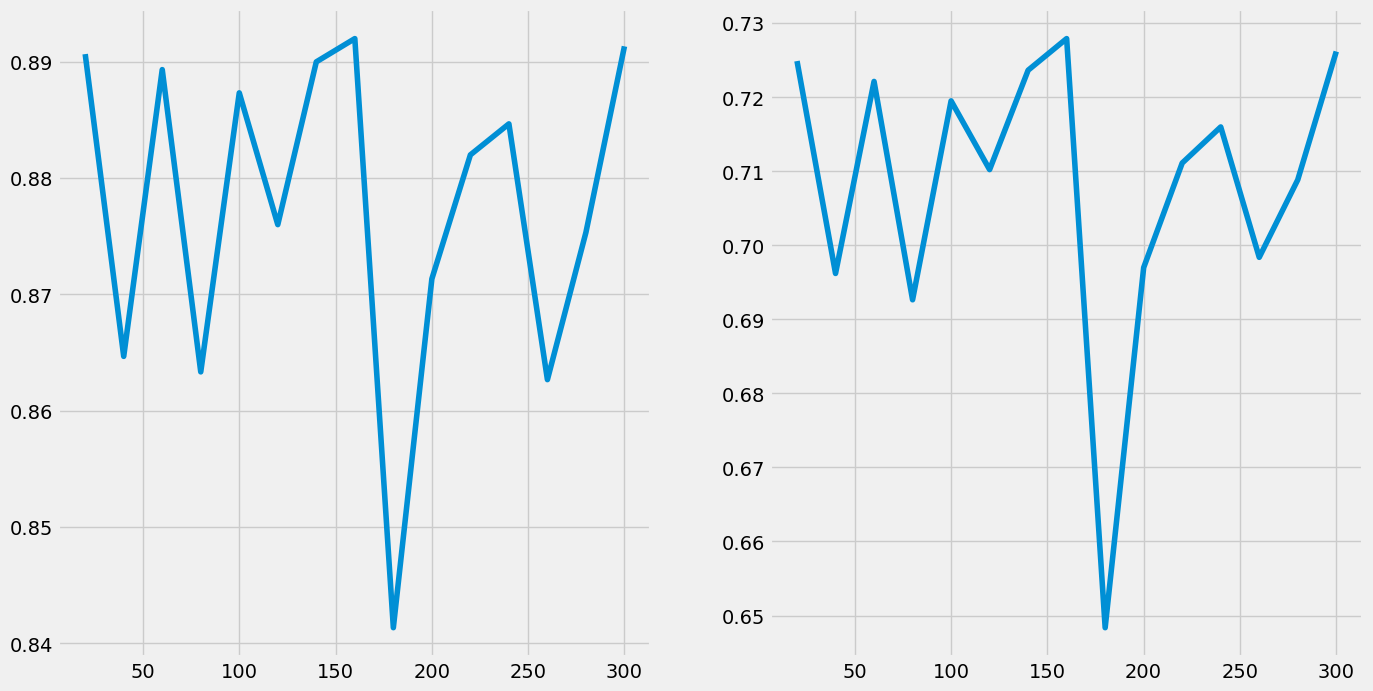

In [7]:
iris_to_plot = [np.mean(x) for x in iris_agreements_Bs]
iris_to_plot_1 = [np.mean(x) for x in iris_rands_Bs]

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].plot(Bs, iris_to_plot)
ax[1].plot(Bs, iris_to_plot_1)
plt.show()

In [8]:
my_own_agreements_Bs = []
my_own_rands_Bs = []
for B in Bs:
    evaluation = eval_((my_own_x, my_own_y), B, c=5, reps=20)
    my_own_agreements_Bs.append(evaluation[0])
    my_own_rands_Bs.append(evaluation[1])

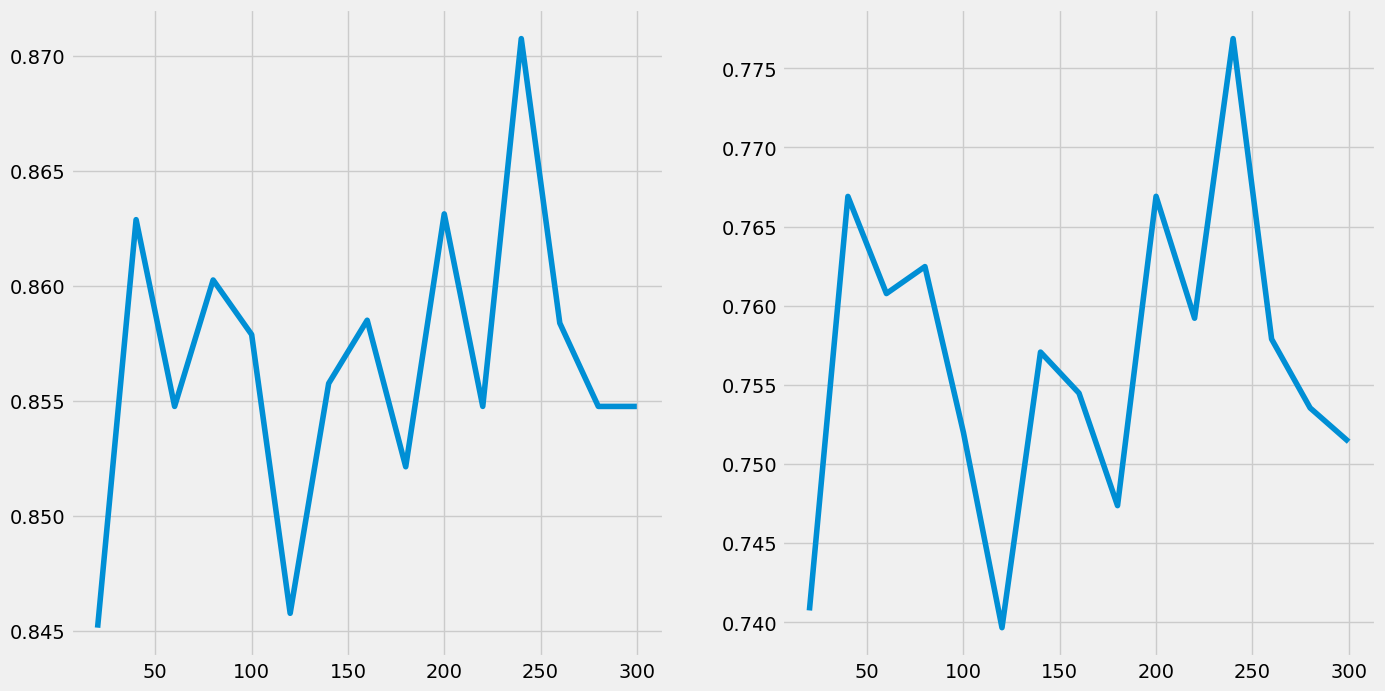

In [9]:
my_own_to_plot = [np.mean(x) for x in my_own_agreements_Bs]
my_own_to_plot_1 = [np.mean(x) for x in my_own_rands_Bs]

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].plot(Bs, my_own_to_plot)
ax[1].plot(Bs, my_own_to_plot_1)
plt.show()

In [10]:
cassini_agreements_Bs = []
cassini_rands_Bs = []
for B in Bs:
    evaluation = eval_((cassini_x, cassini_y), B, c=3, reps=10)
    cassini_agreements_Bs.append(evaluation[0])
    cassini_rands_Bs.append(evaluation[1])

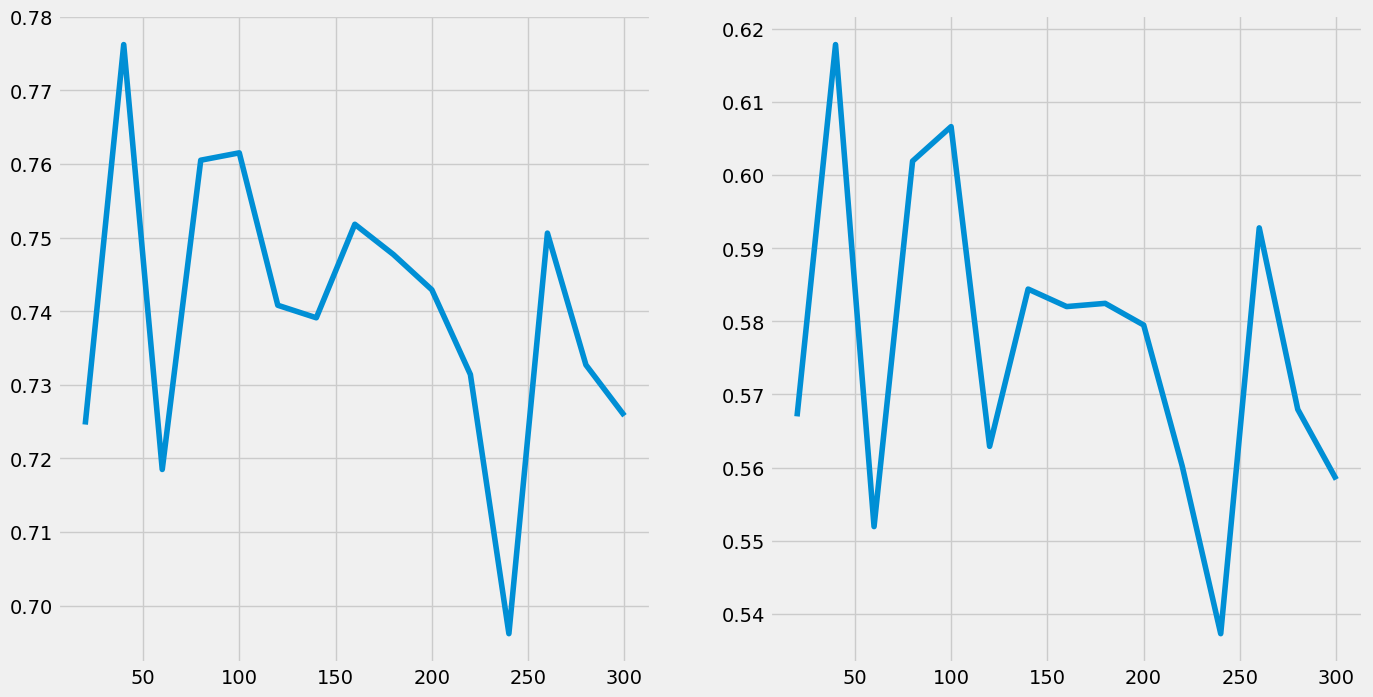

In [11]:
cassini_to_plot = [np.mean(x) for x in cassini_agreements_Bs]
cassini_to_plot_1 = [np.mean(x) for x in cassini_rands_Bs]

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].plot(Bs, cassini_to_plot)
ax[1].plot(Bs, cassini_to_plot_1)
plt.show()

In [12]:
Bs = [int(i) for i in Bs]

In [13]:
bagging_params = {}
bagging_params["Bs"] = Bs 
bagging_params["iris_agree"] = iris_to_plot
bagging_params["iris_rands"] = iris_to_plot_1
bagging_params["my_own_agree"] = my_own_to_plot
bagging_params["my_own_rands"] = my_own_to_plot_1
bagging_params["cassini_agree"] = cassini_to_plot
bagging_params["cassini_rands"] = cassini_to_plot_1

In [14]:
with open("tuning/bagging_params.json", "w") as infile:
    json.dump(bagging_params, infile)

## BaggedEnsemble

In [69]:
def evaluate_Bagged(dataset, center, num, reps=10):
    agreements = 0
    for i in range(reps):
        labs = BaggedEnsemble(clusters=dataset.k, base_centers=center, num_of_partitions=num).fit(dataset.x).labels_
        agreements += clustering_agreement(labs, dataset.y)
    return agreements / reps 

In [58]:
x = np.arange(20, 120, 20)
iris_res = np.zeros((5, 5))
for i in range(5):
    for j in range(5):
        iris_res[i, j] = evaluate_Bagged(iris_, x[j], x[i])

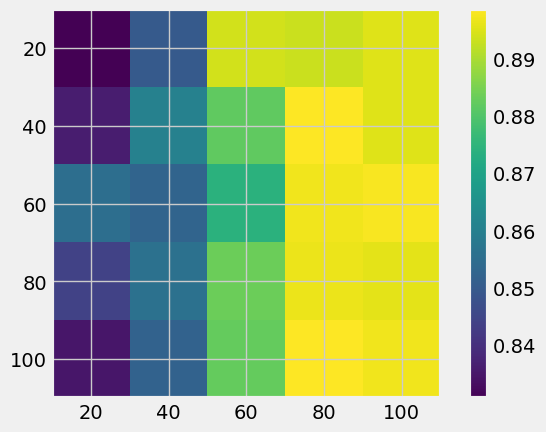

In [82]:
plt.imshow(iris_res, cmap="viridis")
plt.xticks(range(5), x)
plt.yticks(range(5), x)
plt.colorbar()
plt.show()

In [83]:
np.savetxt("tuning/iris_BaggedEnsbemble.txt", iris_res)

In [93]:
my_own_partitions = np.arange(20, 120, 20)
my_own_centers = np.arange(20, 180, 20)

my_own_res = np.zeros((5, 8))

for i in range(5):
    for j in range(8):
        my_own_res[i, j] = evaluate_Bagged(my_own_, my_own_centers[j], my_own_partitions[i])

(5, 8)

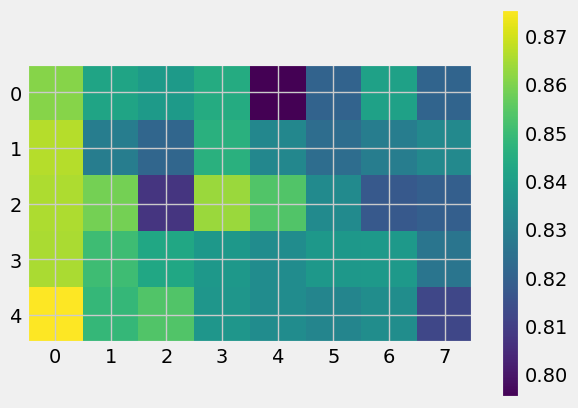

In [107]:
plt.imshow(my_own_res, cmap="viridis")
plt.xticks(range(8), range(8))
plt.yticks(range(5), range(5))
plt.colorbar()
plt.show()

In [109]:
np.savetxt("tuning/my_own_BaggedEnsemble.txt", my_own_res)

In [110]:
cassini_partitions = np.arange(20, 120, 20)
cassini_centers = np.arange(20, 200, 20)

cassini_res = np.zeros((5, 9))

for i in range(5):
    for j in range(9):
        cassini_res[i, j] = evaluate_Bagged(cassini_, cassini_centers[j], cassini_partitions[i])

(5, 9)

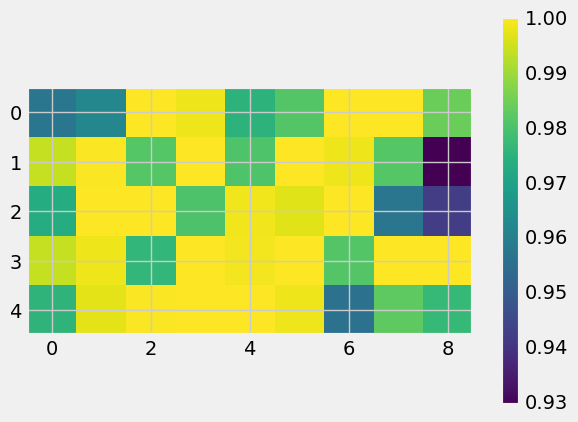

In [114]:
plt.imshow(cassini_res)
plt.xticks(range(9), range(9))
plt.yticks(range(5), range(5))
plt.colorbar()
plt.show()

In [116]:
np.savetxt("tuning/cassini_BaggedEnsemble.txt", cassini_res)

## Choosing different `base_estimator_k` values

In [185]:
def base_estimator_k(algo, k, dataset, reps=10):
    agreements = []
    rands = []
    for rep in range(reps):
        labs = algo(clusters=dataset.k, base_estimator_k=k).fit(dataset.x).labels_
        agreements.append(clustering_agreement(dataset.y, labs))
        rands.append(adjusted_rand_score(dataset.y, labs))
    return np.mean(agreements), np.mean(rands)

def results(algo, ks, dataset, reps=10):
    agreements = []
    rands = []
    for k in ks:
        a, b = base_estimator_k(algo, k, dataset, reps=reps)
        agreements.append(a)
        rands.append(b)
    return agreements, rands

In [186]:
iris_ks = list(range(3, 12))

In [187]:
iris_spec_agree, iris_spec_rands = results(SpectralEnsemble, iris_ks, iris_)

iris_hc_agree, iris_hc_rands = results(HierarchyEnsemble, iris_ks, iris_)

iris_kmodes_agree, iris_kmodes_rands = results(KModesEnsemble, iris_ks, iris_)

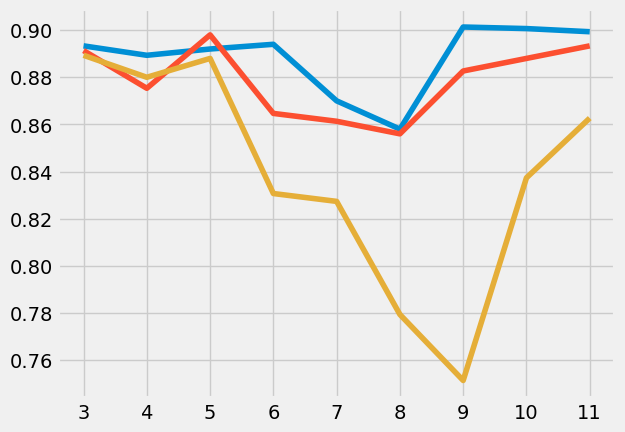

In [188]:
plt.plot(iris_ks, iris_spec_agree)
plt.plot(iris_ks, iris_hc_agree)
plt.plot(iris_ks, iris_kmodes_agree)
plt.show()

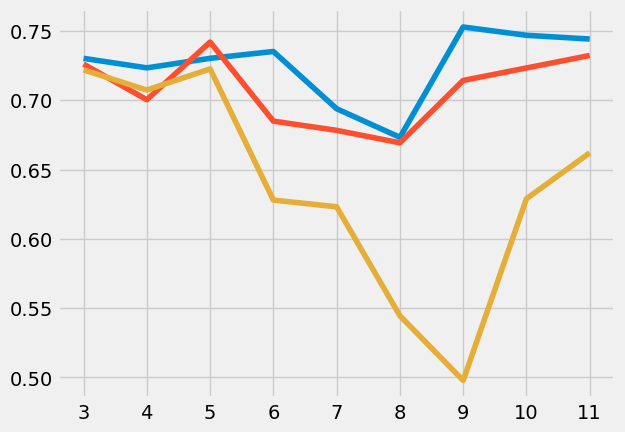

In [189]:
plt.plot(iris_ks, iris_spec_rands)
plt.plot(iris_ks, iris_hc_rands)
plt.plot(iris_ks, iris_kmodes_rands)
plt.show()

In [190]:
my_own_ks = list(range(5, 15))

In [191]:
my_own_spec_agree, my_own_spec_rands = results(SpectralEnsemble, my_own_ks, my_own_)

my_own_hc_agree, my_own_hc_rands = results(HierarchyEnsemble, my_own_ks, my_own_)

my_own_kmodes_agree, my_own_kmodes_rands = results(KModesEnsemble, my_own_ks, my_own_)

In [199]:
iris_agreements = {"ks": iris_ks, "kmodes": iris_kmodes_agree, "spec": iris_spec_agree, "hc": iris_hc_agree}
iris_rands = {"ks": iris_ks, "kmodes": iris_kmodes_rands, "spec": iris_spec_rands, "hc": iris_hc_rands}

for (name, dict_) in zip(["agreement", "rands"], [iris_agreements, iris_rands]):
    with open(f"tuning/iris_{name}.json", "w") as infile:
        json.dump(dict_, infile) 

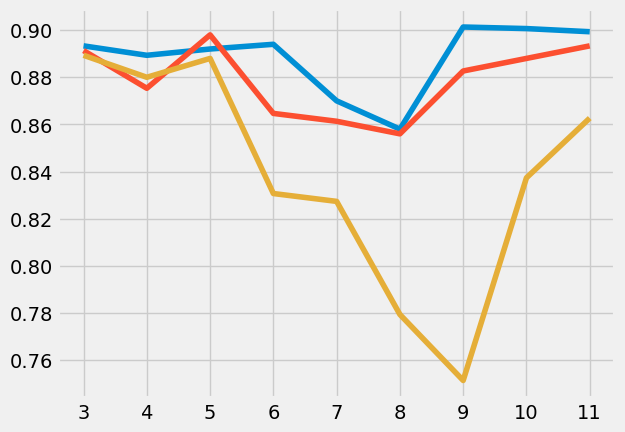

In [192]:
plt.plot(iris_ks, iris_spec_agree)
plt.plot(iris_ks, iris_hc_agree)
plt.plot(iris_ks, iris_kmodes_agree)
plt.show()

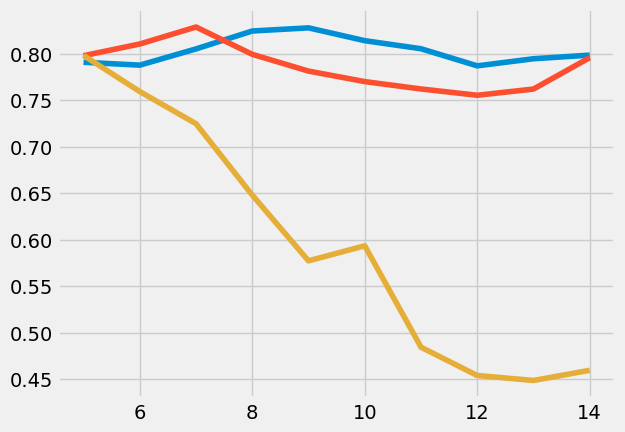

In [193]:
plt.plot(my_own_ks, my_own_spec_rands)
plt.plot(my_own_ks, my_own_hc_rands)
plt.plot(my_own_ks, my_own_kmodes_rands)
plt.show()

In [198]:
my_own_agreements = {"ks": my_own_ks, "kmodes": my_own_kmodes_agree, "spec": my_own_spec_agree, "hc": my_own_hc_agree}
my_own_rands = {"ks": my_own_ks, "kmodes": my_own_kmodes_rands, "spec": my_own_spec_rands, "hc": my_own_hc_rands}

for (name, dict_) in zip(["agreement", "rands"], [my_own_agreements, my_own_rands]):
    with open(f"tuning/my_own_{name}.json", "w") as infile:
        json.dump(dict_, infile)    

In [200]:
cassini_ks = list(range(3, 10))

In [201]:
casssini_spec_agree, cassini_spec_rands = results(SpectralEnsemble, cassini_ks, cassini_)

cassini_hc_agree, cassini_hc_rands = results(HierarchyEnsemble, cassini_ks, cassini_)

cassini_kmodes_agree, cassini_kmodes_rands = results(KModesEnsemble, cassini_ks, cassini_)

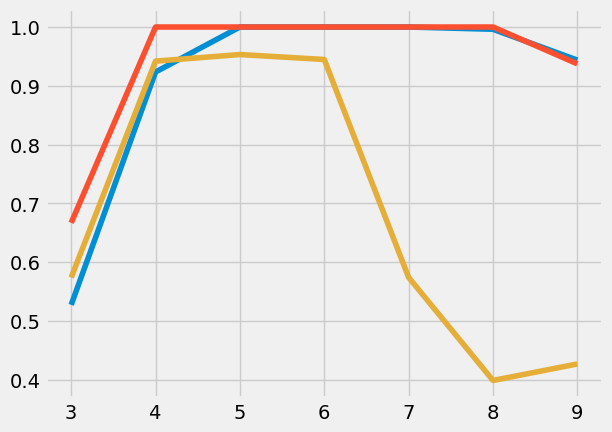

In [202]:
plt.plot(cassini_ks, cassini_spec_rands)
plt.plot(cassini_ks, cassini_hc_rands)
plt.plot(cassini_ks, cassini_kmodes_rands)
plt.show()

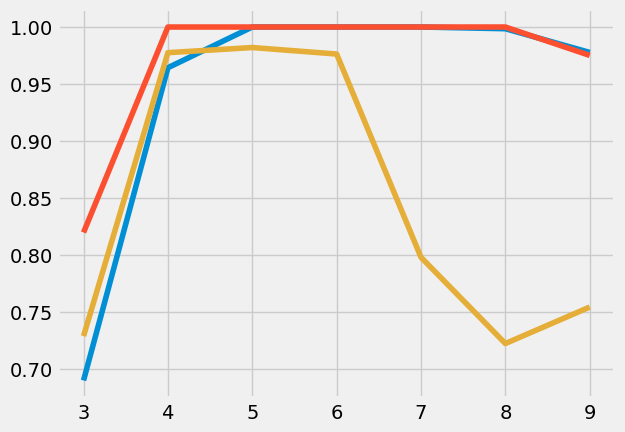

In [207]:
plt.plot(cassini_ks, casssini_spec_agree)
plt.plot(cassini_ks, cassini_hc_agree)
plt.plot(cassini_ks, cassini_kmodes_agree)
plt.show()

In [210]:
cassini_agreements = {"ks": cassini_ks, "kmodes": cassini_kmodes_agree,
                      "spec": casssini_spec_agree, "hc": cassini_hc_agree}
cassini_rands = {"ks": cassini_ks, "kmodes": cassini_kmodes_rands, 
                 "spec": cassini_spec_rands, "hc": cassini_hc_rands}

for (name, dict_) in zip(["agreement", "rands"], [cassini_agreements, cassini_rands]):
    with open(f"tuning/cassini_{name}.json", "w") as infile:
        json.dump(dict_, infile)    

# Methods vs `num_of_partitions`

In [15]:
nums_of_partitions = np.arange(20, 220, 20)

In [9]:
def evaluate_algorithm(algorithm, dataset, K, num_of_partitions, reps=10):
    accuracy_ = 0
    for i in range(reps):
        labs = algorithm(clusters=dataset.k, base_estimator_k=K, num_of_partitions=num_of_partitions).fit(dataset.x).labels_
        accuracy_ += clustering_agreement(dataset.y, labs)
    return accuracy_ / reps

In [16]:
# iris
iris_kmodes = np.vectorize(lambda x: evaluate_algorithm(KModesEnsemble, iris_, 5, x))(nums_of_partitions)
iris_spectral = np.vectorize(lambda x: evaluate_algorithm(SpectralEnsemble, iris_, 5, x))(nums_of_partitions)
iris_hc = np.vectorize(lambda x: evaluate_algorithm(HierarchyEnsemble, iris_, 5, x))(nums_of_partitions)

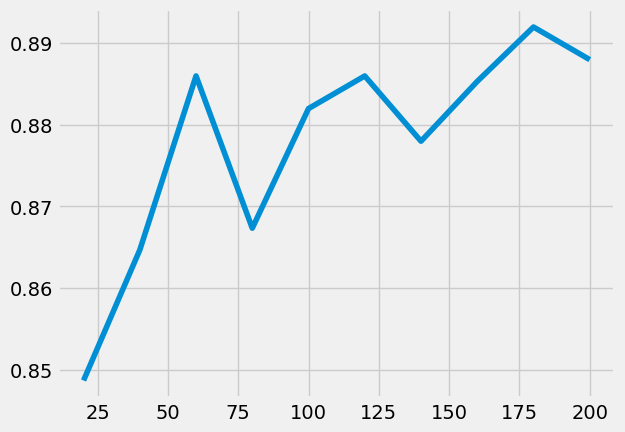

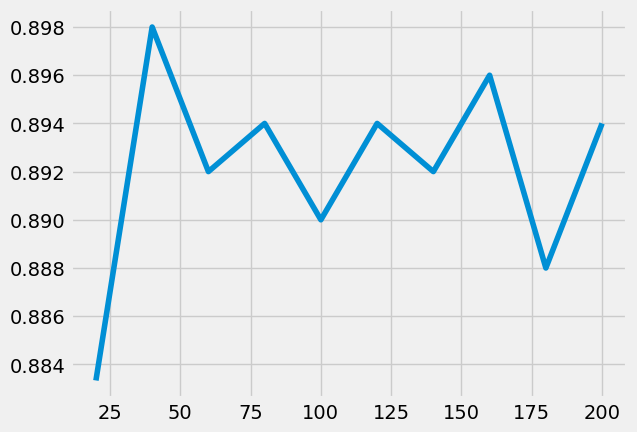

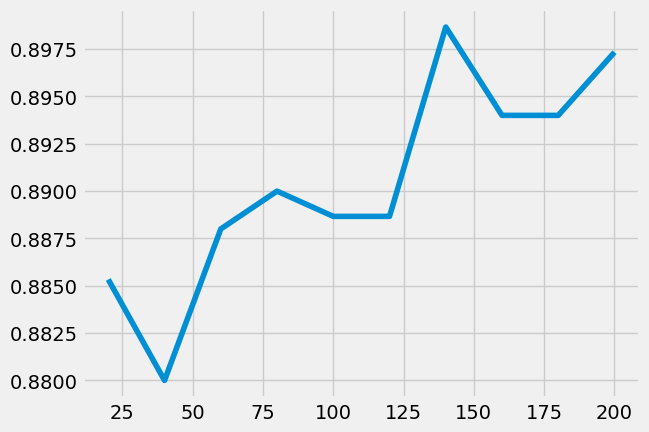

In [17]:
for i in [iris_kmodes, iris_spectral, iris_hc]:
    plt.plot(nums_of_partitions, i)
    plt.show()

In [20]:
iris_partitions = dict()

iris_partitions["partitions"] = [int(i) for i in nums_of_partitions]
iris_partitions["KModesEnsemble"] = [float(i) for i in iris_kmodes]
iris_partitions["HierarchicalEnsemble"] = [float(i) for i in iris_hc]
iris_partitions["SpectralEnsemble"] = [float(i) for i in iris_spectral]

with open("tuning/iris_partitions.json", "w") as infile:
    json.dump(iris_partitions, infile)

In [21]:
# my_own
my_own_kmodes = np.vectorize(lambda x: evaluate_algorithm(KModesEnsemble, my_own_, 5, x))(nums_of_partitions)
my_own_spectral = np.vectorize(lambda x: evaluate_algorithm(SpectralEnsemble, my_own_, 20, x))(nums_of_partitions)
my_own_hc = np.vectorize(lambda x: evaluate_algorithm(HierarchyEnsemble, my_own_, 25, x))(nums_of_partitions)

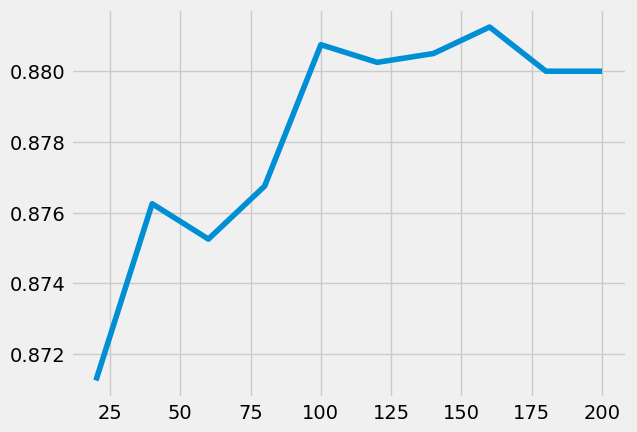

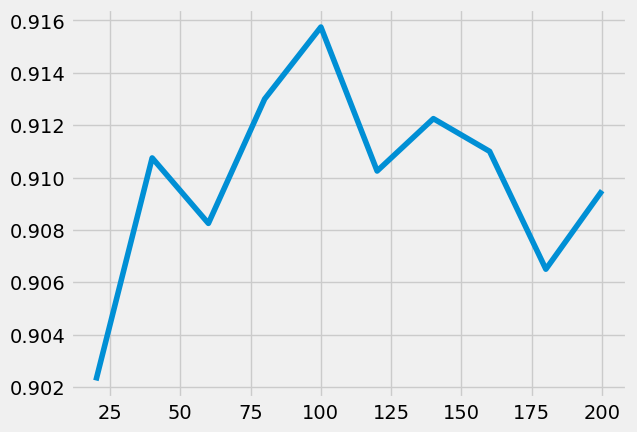

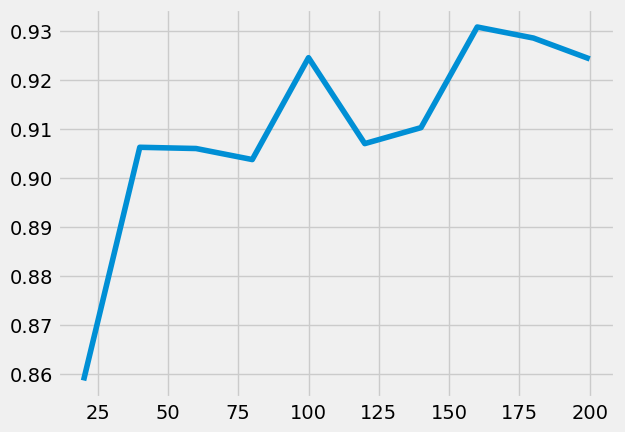

In [22]:
for i in [my_own_kmodes, my_own_spectral, my_own_hc]:
    plt.plot(nums_of_partitions, i)
    plt.show()

In [23]:
my_own_partitions = dict()

my_own_partitions["partitions"] = [int(i) for i in nums_of_partitions]
my_own_partitions["KModesEnsemble"] = [float(i) for i in my_own_kmodes]
my_own_partitions["HierarchicalEnsemble"] = [float(i) for i in my_own_hc]
my_own_partitions["SpectralEnsemble"] = [float(i) for i in my_own_spectral]

with open("tuning/my_own_partitions.json", "w") as infile:
    json.dump(my_own_partitions, infile)

In [24]:
# cassini
cassini_kmodes = np.vectorize(lambda x: evaluate_algorithm(KModesEnsemble, cassini_, 6, x))(nums_of_partitions)
cassini_spectral = np.vectorize(lambda x: evaluate_algorithm(SpectralEnsemble, cassini_, 6, x))(nums_of_partitions)
cassini_hc = np.vectorize(lambda x: evaluate_algorithm(HierarchyEnsemble, cassini_, 6, x))(nums_of_partitions)

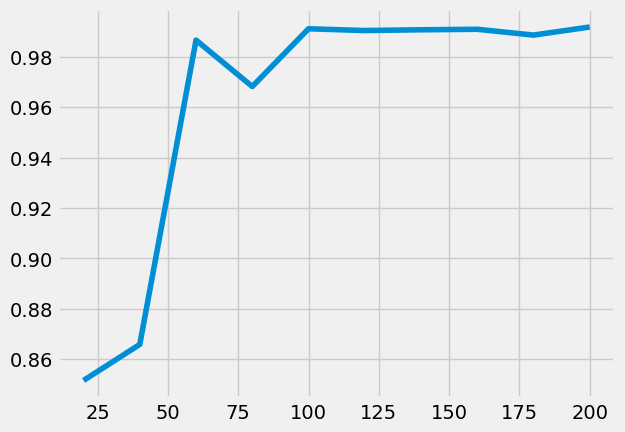

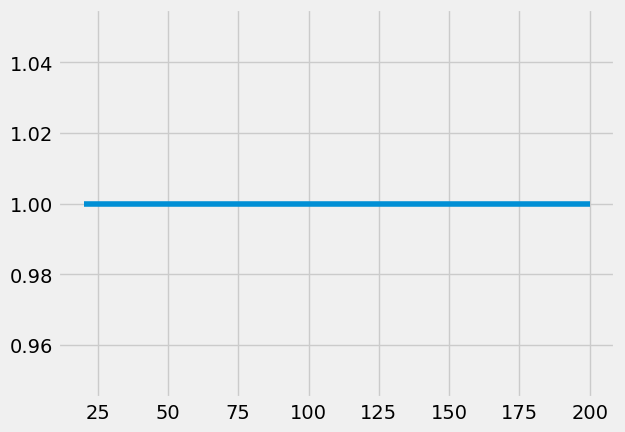

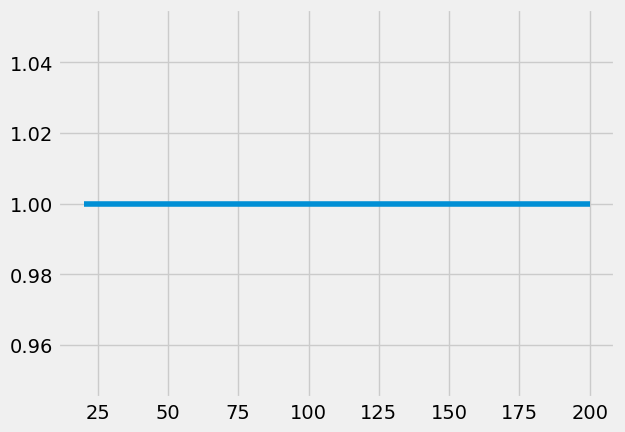

In [25]:
for i in [cassini_kmodes, cassini_spectral, cassini_hc]:
    plt.plot(nums_of_partitions, i)
    plt.show()

In [27]:
cassini_partitions = dict()

cassini_partitions["partitions"] = [int(i) for i in nums_of_partitions]
cassini_partitions["KModesEnsemble"] = [float(i) for i in cassini_kmodes]
cassini_partitions["HierarchicalEnsemble"] = [float(i) for i in cassini_hc]
cassini_partitions["SpectralEnsemble"] = [float(i) for i in cassini_spectral]

with open("tuning/cassini_partitions.json", "w") as infile:
    json.dump(cassini_partitions, infile)